## Table of Contents
- [Introduction](#intro)
- [Gathering Data](#gathering)
- [Assessing Data](#assess)
- [Cleaning Data](#clean)
- [Storing](#storing)
- [Analyzing, and Visualizing Data](#visualize)


<a id='intro'></a>
### Introduction

For this project, we will be working to wrangle and analyze the WeRateDogs Twitter archive. Our goal is to work through this notebook to detect and document at least eight (8) quality issues and two (2) tidiness issues. We shall then clean each of the issues we documented while assessing. 


In [1]:
# import statements
import pandas as pd
import numpy as np
import tweepy
import requests
import os
import json
import re
import time

import matplotlib.pyplot as plt
%matplotlib inline

<a id='gathering'></a>
### Gathering Data

Gather each of the three pieces of data as described below:

- The WeRateDogs Twitter archive. 

- The tweet image predictions, i.e., what breed of dog (or other object, animal, etc.) is present in each tweet according to a neural network. This file (image_predictions.tsv) is hosted on Udacity's servers and should be downloaded programmatically using the Requests library and the following URL: https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv

- Each tweet's retweet count and favorite ("like") count at minimum, and any additional data you find interesting. Using the tweet IDs in the WeRateDogs Twitter archive, query the Twitter API for each tweet's JSON data using Python's Tweepy library and store each tweet's entire set of JSON data in a file called tweet_json.txt file. Each tweet's JSON data should be written to its own line. Then read this .txt file line by line into a pandas DataFrame with (at minimum) tweet ID, retweet count, and favorite count. 

In [2]:
# load the WeRateDogs Twitter Archive
twitter_archive = pd.read_csv('twitter-archive-enhanced.csv')

In [3]:
# get the tweet image predictions file from the udacity website
url = 'https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv' 
response = requests.get(url)
with open(os.path.join('image_predictions.tsv'), mode = 'wb') as file:
    file.write(response.content)
    
# load the image prediction into a data frame
images = pd.read_csv('image_predictions.tsv', sep = '\t')

In [4]:
# declare twitter API keys and access tokens
consumer_key = 'CONSUMER_KEY'
consumer_secret = 'CONSUMER_SECRET'
access_token = 'ACCESS_TOKEN'
access_token_secret = 'ACCESS_TOKEN_SECRET'

In [5]:
# create an API object that we can use to gather Twitter data.
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)

api = tweepy.API(auth, wait_on_rate_limit=True, wait_on_rate_limit_notify=True)

In [6]:
# use tweet IDs in the WeRateDogs archive to query the twitter API for each tweet's JSON data 

tweet_ids = list(twitter_archive['tweet_id'])

df_list = []
tweet_id_is_missing = []

start_time = time.time()

# add tweet json to df_list
for tweet_id in tweet_ids:
    try:
        tweet = api.get_status(tweet_id, tweet_mode='extended')._json
        favorite_count = tweet['favorite_count']
        retweet_count = tweet['retweet_count']
        
        df_list.append({'tweet_id': int(tweet_id), 'favorite_count': int(favorite_count), 'retweet_count': int(retweet_count)})
    except Exception as e:
        print(str(tweet_id)+ " " + str(e))
        tweet_id_is_missing.append(tweet_id)
        
end_time = time.time()


888202515573088257 [{'code': 144, 'message': 'No status found with that ID.'}]
873697596434513921 [{'code': 144, 'message': 'No status found with that ID.'}]
872668790621863937 [{'code': 144, 'message': 'No status found with that ID.'}]
872261713294495745 [{'code': 144, 'message': 'No status found with that ID.'}]
869988702071779329 [{'code': 144, 'message': 'No status found with that ID.'}]
866816280283807744 [{'code': 144, 'message': 'No status found with that ID.'}]
861769973181624320 [{'code': 144, 'message': 'No status found with that ID.'}]
856602993587888130 [{'code': 144, 'message': 'No status found with that ID.'}]
851953902622658560 [{'code': 144, 'message': 'No status found with that ID.'}]
845459076796616705 [{'code': 144, 'message': 'No status found with that ID.'}]
844704788403113984 [{'code': 144, 'message': 'No status found with that ID.'}]
842892208864923648 [{'code': 144, 'message': 'No status found with that ID.'}]
837366284874571778 [{'code': 144, 'message': 'No sta

Rate limit reached. Sleeping for: 191


669216679721873412 Failed to send request: HTTPSConnectionPool(host='api.twitter.com', port=443): Read timed out. (read timeout=60)


In [62]:
print('Length of tweet data', len(df_list))
print('Length of missing tweet data', len(tweet_id_is_missing))
print('Time taken', end_time-start_time)

Length of tweet data 2330
Length of missing tweet data 26
Time taken 8031.61425113678


In [63]:
# save json to tweet_json.txt file
json_tweets = pd.DataFrame(df_list, columns=['tweet_id', 'favorite_count', 'retweet_count'])
json_tweets.to_csv('tweet_json.txt', encoding='utf-8', index=False)

In [64]:
# read data
tweet_data = pd.read_csv('tweet_json.txt', encoding='utf-8')
tweet_data

,tweet_id,favorite_count,retweet_count
0,892420643555336193,37087,7923
1,892177421306343426,31912,5886
2,891815181378084864,24024,3886
3,891689557279858688,40412,8078
4,891327558926688256,38628,8756
...,...,...,...
2325,666049248165822465,101,41
2326,666044226329800704,280,135
2327,666033412701032449,119,43
2328,666029285002620928,123,45


<a id='assess'></a>
### Assessing Data

After gathering each of the above pieces of data, assess them visually and programmatically for quality and tidiness issues. Detect and document at least eight (8) quality issues and two (2) tidiness issues.

Key points to keep in mind when data wrangling for this project:

- You only want original ratings (no retweets) that have images. Though there are 5000+ tweets in the dataset, not all are dog ratings and some are retweets.

In [65]:
# load a sample of the twitter archive
twitter_archive.sample(4)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
382,827228250799742977,NaN,NaN,2017-02-02 18:52:38 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: This is Phil. He's an important...,6.946697e+17,4.196984e+09,2016-02-02 23:52:22 +0000,https://twitter.com/dog_rates/status/694669722...,12,10,Phil,None,None,None,None
209,852226086759018497,NaN,NaN,2017-04-12 18:25:07 +0000,"<a href=""http://twitter.com"" rel=""nofollow"">Tw...",Meet General. He wasn't content with the quali...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/852226086...,14,10,General,None,None,None,None
137,866094527597207552,NaN,NaN,2017-05-21 00:53:21 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: Here's a pupper before and afte...,8.378202e+17,4.196984e+09,2017-03-04 00:21:08 +0000,https://twitter.com/dog_rates/status/837820167...,12,10,None,None,None,pupper,None
629,794355576146903043,NaN,NaN,2016-11-04 01:48:22 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: This is Butter. She can have wh...,7.887659e+17,4.196984e+09,2016-10-19 15:37:03 +0000,https://twitter.com/dog_rates/status/788765914...,12,10,Butter,None,None,None,None


In [66]:
twitter_archive.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

In [67]:
twitter_archive.describe()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,retweeted_status_id,retweeted_status_user_id,rating_numerator,rating_denominator
count,2.356000e+03,7.800000e+01,7.800000e+01,1.810000e+02,1.810000e+02,2356.000000,2356.000000
mean,7.427716e+17,7.455079e+17,2.014171e+16,7.720400e+17,1.241698e+16,13.126486,10.455433
std,6.856705e+16,7.582492e+16,1.252797e+17,6.236928e+16,9.599254e+16,45.876648,6.745237
min,6.660209e+17,6.658147e+17,1.185634e+07,6.661041e+17,7.832140e+05,0.000000,0.000000
25%,6.783989e+17,6.757419e+17,3.086374e+08,7.186315e+17,4.196984e+09,10.000000,10.000000
50%,7.196279e+17,7.038708e+17,4.196984e+09,7.804657e+17,4.196984e+09,11.000000,10.000000
75%,7.993373e+17,8.257804e+17,4.196984e+09,8.203146e+17,4.196984e+09,12.000000,10.000000
max,8.924206e+17,8.862664e+17,8.405479e+17,8.874740e+17,7.874618e+17,1776.000000,170.000000


In [68]:
# are there any records in the twitter archive that are retweets
len(twitter_archive[twitter_archive.retweeted_status_id.isnull() == False])

181

In [69]:
# records in twitter archive missing in the image prediction dataframe
len(twitter_archive[~twitter_archive.tweet_id.isin(images.tweet_id)])

281

In [70]:
twitter_archive['doggo'].value_counts()

None     2259
doggo      97
Name: doggo, dtype: int64

In [72]:
twitter_archive['floofer'].value_counts()

None       2346
floofer      10
Name: floofer, dtype: int64

In [73]:
twitter_archive['pupper'].value_counts()

None      2099
pupper     257
Name: pupper, dtype: int64

In [74]:
twitter_archive['puppo'].value_counts()

None     2326
puppo      30
Name: puppo, dtype: int64

In [75]:
# data type for timestamp
type(twitter_archive['timestamp'][0])

str

In [76]:
twitter_archive.name.value_counts().sort_index(ascending=True)

Abby            2
Ace             1
Acro            1
Adele           1
Aiden           1
               ..
such            1
the             8
this            1
unacceptable    1
very            5
Name: name, Length: 957, dtype: int64

In [77]:
# load a sample of the image prediction data frame
images.sample(4)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
846,695314793360662529,https://pbs.twimg.com/media/CaZBErSWEAEdXk_.jpg,2,Maltese_dog,0.678547,True,Lhasa,0.125046,True,Pekinese,0.048999,True
1527,788908386943430656,https://pbs.twimg.com/media/CvLD-mbWYAAFI8w.jpg,1,remote_control,0.881538,False,oscilloscope,0.035513,False,golden_retriever,0.034090,True
1026,710833117892898816,https://pbs.twimg.com/media/Cd1i8qvUkAE-Jlr.jpg,1,Pembroke,0.803742,True,Cardigan,0.189712,True,German_shepherd,0.001746,True
1809,832757312314028032,https://pbs.twimg.com/media/C46MWnFVYAUg1RK.jpg,2,Cardigan,0.160888,True,Staffordshire_bullterrier,0.159441,True,Boston_bull,0.154368,True


In [78]:
images.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null int64
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [79]:
# duplicated images
sum(images.jpg_url.duplicated())

66

In [80]:
images.describe()

,tweet_id,img_num,p1_conf,p2_conf,p3_conf
count,2.075000e+03,2075.000000,2075.000000,2.075000e+03,2.075000e+03
mean,7.384514e+17,1.203855,0.594548,1.345886e-01,6.032417e-02
std,6.785203e+16,0.561875,0.271174,1.006657e-01,5.090593e-02
min,6.660209e+17,1.000000,0.044333,1.011300e-08,1.740170e-10
25%,6.764835e+17,1.000000,0.364412,5.388625e-02,1.622240e-02
50%,7.119988e+17,1.000000,0.588230,1.181810e-01,4.944380e-02
75%,7.932034e+17,1.000000,0.843855,1.955655e-01,9.180755e-02
max,8.924206e+17,4.000000,1.000000,4.880140e-01,2.734190e-01


In [81]:
images.p1.value_counts()

golden_retriever      150
Labrador_retriever    100
Pembroke               89
Chihuahua              83
pug                    57
                     ... 
cougar                  1
cliff                   1
fountain                1
coil                    1
scorpion                1
Name: p1, Length: 378, dtype: int64

In [82]:
images.p2.value_counts()

Labrador_retriever    104
golden_retriever       92
Cardigan               73
Chihuahua              44
Pomeranian             42
                     ... 
crib                    1
comic_book              1
sarong                  1
cab                     1
television              1
Name: p2, Length: 405, dtype: int64

In [83]:
images.p3.value_counts()

Labrador_retriever    79
Chihuahua             58
golden_retriever      48
Eskimo_dog            38
kelpie                35
                      ..
mosquito_net           1
gorilla                1
mushroom               1
gar                    1
cowboy_boot            1
Name: p3, Length: 408, dtype: int64

In [84]:
tweet_data.head()

,tweet_id,favorite_count,retweet_count
0,892420643555336193,37087,7923
1,892177421306343426,31912,5886
2,891815181378084864,24024,3886
3,891689557279858688,40412,8078
4,891327558926688256,38628,8756


In [85]:
tweet_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2330 entries, 0 to 2329
Data columns (total 3 columns):
tweet_id          2330 non-null int64
favorite_count    2330 non-null int64
retweet_count     2330 non-null int64
dtypes: int64(3)
memory usage: 54.7 KB


In [86]:
tweet_data.describe()

,tweet_id,favorite_count,retweet_count
count,2.330000e+03,2330.000000,2330.000000
mean,7.419441e+17,7741.863948,2791.203863
std,6.823142e+16,12013.689905,4722.673979
min,6.660209e+17,0.000000,1.000000
25%,6.782926e+17,1351.250000,561.750000
50%,7.183508e+17,3371.500000,1304.000000
75%,7.986712e+17,9496.750000,3249.250000
max,8.924206e+17,160286.000000,80133.000000


### Quality Issues
These are issues with content. 

#### twitter archive data frame

- Has retweets and therefore data may be duplicated
- Missing tweet ids of twitter archive data frame in images data frame
- Has columns that are not needed for analysis
- Incorrect datatype for timestamp which is indicated as string and not date time
- dog names starting with lowercase letters and some unusual dog names for example a, such, the, this, unacceptable, e.t.c

#### images data frame

- duplicated jpg_url
- p1, p2, p3 columns have underscore instead of space
- inconsistent capital letters in p1, p2 and p3


### Tidiness Issues
These are issues with structure that prevent easy analysis.

- doggo, floofer, pupper, and puppo columns in twitter_archive should be in one column "stage"
- all three data frames should be one data frame as they have similar data for tweets

<a id='clean'></a>
### Cleaning Data

Clean each of the issues you documented while assessing. Perform this cleaning in

In [124]:
# Make a copy of the data frames on which the cleaning will be performed
twitter_archive_clean = twitter_archive.copy()
images_clean = images.copy()
tweet_data_clean = tweet_data.copy()

#### Quality 1: Has retweets and therefore data may be duplicated

#### Define
Remove all retweets from the twitter archive data and keep only original data

#### Code

In [125]:
twitter_archive_clean = twitter_archive_clean[twitter_archive_clean.retweeted_status_id.isnull()]

#### Test

In [126]:
len(twitter_archive_clean[twitter_archive_clean.retweeted_status_id.isnull() == False])

0

#### Quality 2: Missing tweet ids of twitter archive data frame in images data frame

#### Define
Keep tweet ids in twitter archive table if and ond only if they exist in the images data frame

#### Code


In [127]:
twitter_archive_clean = twitter_archive_clean[twitter_archive_clean.tweet_id.isin(images_clean.tweet_id)]

#### Test

In [128]:
len(twitter_archive_clean[~twitter_archive_clean.tweet_id.isin(images_clean.tweet_id)])

0

#### Quality 3: Has columns that are not needed for analysis

#### Define
Remove columns that are not needed for analysis e.g. `in_reply_to_status_id` and `in_reply_to_user_id` only have 78 records and `retweeted_status_id`, `retweeted_status_user_id`, and `retweeted_status_timestamp` only have 181 records and we are trying to focus on original data not retweet data.

#### Code

In [129]:
twitter_archive_clean.drop(['in_reply_to_status_id', 'in_reply_to_user_id', 'retweeted_status_id', 'retweeted_status_user_id',
                           'retweeted_status_timestamp'], axis=1, inplace=True)

#### Test

In [130]:
twitter_archive_clean.columns

Index(['tweet_id', 'timestamp', 'source', 'text', 'expanded_urls',
       'rating_numerator', 'rating_denominator', 'name', 'doggo', 'floofer',
       'pupper', 'puppo'],
      dtype='object')

#### Quality 4: Incorrect datatype for timestamp which is indicated as string and not date time

#### Define
Change datatype for timestamp to datetime

#### Code

In [131]:
twitter_archive_clean['timestamp'] = pd.to_datetime(twitter_archive_clean['timestamp'])

#### Test

In [132]:
type(twitter_archive_clean['timestamp'][0])

pandas._libs.tslibs.timestamps.Timestamp

#### Quality 5: dog names starting with lowercase letters and some unusual dog names for example a, such, the, this, unacceptable, e.t.c

#### Define
Ensure that all dog names start with an upper case letter. Replace all unusual names with NaN. In cases where name is None. Replace it with NaN as well.

#### Code


In [133]:
# Find all names that start with a lowercase letter
lowercase_names = []
for row in twitter_archive_clean['name']:
    if row[0].islower() and row not in lowercase_names:
        lowercase_names.append(row)
print(lowercase_names)

['such', 'a', 'quite', 'one', 'incredibly', 'very', 'my', 'not', 'his', 'an', 'just', 'getting', 'this', 'unacceptable', 'all', 'infuriating', 'the', 'actually', 'by', 'officially', 'light', 'space']


In [134]:
# Replace all names that start with a lowercase letter with a NaN
twitter_archive_clean['name'].replace(lowercase_names, 
                        np.nan,
                       inplace = True)

In [135]:
# Replace all 'None's with a NaN
twitter_archive_clean['name'].replace('None', 
                        np.nan,
                       inplace = True)

In [136]:
# capitalize all names
twitter_archive_clean['name'] = twitter_archive_clean['name'].str.capitalize()

#### Test

In [137]:
twitter_archive_clean.name.value_counts()

Charlie       11
Cooper        10
Oliver        10
Lucy          10
Penny          9
              ..
Obie           1
Cali           1
Arnie          1
Chompsky       1
Brandonald     1
Name: name, Length: 913, dtype: int64

#### Quality 6: duplicated jpg_url

#### Define
Remove all duplicated jpg_url in the images data frame

#### Code

In [138]:
images_clean = images_clean.drop_duplicates(subset='jpg_url', keep='last')

#### Test

In [139]:
sum(images_clean.jpg_url.duplicated())

0

#### Quality 7: p1, p2, p3 columns have underscore instead of space

#### Define
Remove underscore from p1, p2, and p3 columns. 

#### Code

In [140]:
# Remove underscore from p1, p2, p3
images_clean['p1'] = images_clean['p1'].str.replace('_', ' ')
images_clean['p2'] = images_clean['p2'].str.replace('_', ' ')
images_clean['p3'] = images_clean['p3'].str.replace('_', ' ')

#### Test
Test to see if underscore was removed from p1, p2 and p3

In [141]:
images_clean.p1.value_counts()

golden retriever      139
Labrador retriever     95
Pembroke               88
Chihuahua              79
pug                    55
                     ... 
polecat                 1
Egyptian cat            1
binoculars              1
fiddler crab            1
scorpion                1
Name: p1, Length: 378, dtype: int64

In [142]:
images_clean.p2.value_counts()

Labrador retriever    96
golden retriever      83
Cardigan              72
Chihuahua             43
French bulldog        40
                      ..
snowmobile             1
barbershop             1
lesser panda           1
volcano                1
mud turtle             1
Name: p2, Length: 405, dtype: int64

In [143]:
images_clean.p3.value_counts()

Labrador retriever    76
Chihuahua             57
golden retriever      46
Eskimo dog            36
kelpie                33
                      ..
golfcart               1
cheetah                1
barbell                1
drumstick              1
common newt            1
Name: p3, Length: 408, dtype: int64

#### Quality 8: inconsistent capital letters in p1, p2 and p3

#### Define
Make the first letter as an upper case letter in p1, p2, and p3 columns

#### Code

In [144]:
# Have the first letter as an upper case letter in p1, p2, p3 columns
images_clean['p1'] = images_clean['p1'].str.capitalize()
images_clean['p2'] = images_clean['p2'].str.capitalize()
images_clean['p3'] = images_clean['p3'].str.capitalize()

#### Test
Check to see if every first letter in p1, p2 and p3 columns is upper case

In [145]:
images_clean.p1.value_counts()

Golden retriever      139
Labrador retriever     95
Pembroke               88
Chihuahua              79
Pug                    55
                     ... 
Cup                     1
Pitcher                 1
Toilet seat             1
Maze                    1
Park bench              1
Name: p1, Length: 378, dtype: int64

In [146]:
images_clean.p2.value_counts()

Labrador retriever    96
Golden retriever      83
Cardigan              73
Chihuahua             43
French bulldog        40
                      ..
Hamper                 1
Moped                  1
Confectionery          1
Shower curtain         1
Oxygen mask            1
Name: p2, Length: 404, dtype: int64

In [147]:
images_clean.p3.value_counts()

Labrador retriever    76
Chihuahua             57
Golden retriever      46
Eskimo dog            36
Kelpie                33
                      ..
Beach wagon            1
Assault rifle          1
Triceratops            1
Pier                   1
Park bench             1
Name: p3, Length: 408, dtype: int64

#### Tidiness 1: doggo, floofer, pupper, and puppo columns in twitter_archive should be in one column "stage"

#### Define
Merge doggo, floofer, pupper and puppo columns into one column named `stage`. Drop the columns doggo, floofer, pupper and puppo after merging

#### Code

In [149]:
# Merge doggo, floofer, pupper and puppo columns into one column named stage
twitter_archive_clean['stage'] = twitter_archive_clean[['doggo', 'floofer','pupper','puppo']].apply(lambda x: ''.join(x), axis=1)
twitter_archive_clean['stage'].replace("NoneNoneNoneNone","None ", inplace=True) # fill with none if all None
twitter_archive_clean['stage'].replace("doggoNoneNoneNone","doggo", inplace=True)# fill with doggo if doggo is present
twitter_archive_clean['stage'].replace("NoneflooferNoneNone","floofer", inplace=True)# fill with floofer if floofer is present
twitter_archive_clean['stage'].replace("NoneNonepupperNone","pupper", inplace=True)# fill with pupper if pupper is present
twitter_archive_clean['stage'].replace("NoneNoneNonepuppo","puppo", inplace=True)# fill with puppo if puppo is present
twitter_archive_clean['stage'].replace("doggoNoneNonepuppo",('doggo ,puppo'), inplace=True) # fill with puppo and doggo if both is present
twitter_archive_clean['stage'].replace("doggoNonepupperNone",('doggo ,pupper'), inplace=True)
twitter_archive_clean['stage'].replace("doggoflooferNoneNone",('doggo ,floofer'), inplace=True)


In [150]:
# drop the columns doggo, floofer, pupper and puppo 
twitter_archive_clean.drop(['doggo','floofer', 'pupper','puppo'], axis=1, inplace= True)

#### Test

In [151]:
twitter_archive_clean.columns

Index(['tweet_id', 'timestamp', 'source', 'text', 'expanded_urls',
       'rating_numerator', 'rating_denominator', 'name', 'stage'],
      dtype='object')

#### Tidiness 2: all three data frames should be one data frame as they have similar data for tweets

#### Define
Merge all three data frames(tweet_data_clean, images_clean,twitter_archive_clean) into one data frame

#### Code

In [152]:
df = pd.merge(twitter_archive_clean, images_clean, on ='tweet_id', how= 'inner' )
df = pd.merge(df, tweet_data_clean, on = 'tweet_id', how = 'inner' )

#### Test

In [153]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1920 entries, 0 to 1919
Data columns (total 22 columns):
tweet_id              1920 non-null int64
timestamp             1920 non-null datetime64[ns, UTC]
source                1920 non-null object
text                  1920 non-null object
expanded_urls         1920 non-null object
rating_numerator      1920 non-null int64
rating_denominator    1920 non-null int64
name                  1295 non-null object
stage                 1920 non-null object
jpg_url               1920 non-null object
img_num               1920 non-null int64
p1                    1920 non-null object
p1_conf               1920 non-null float64
p1_dog                1920 non-null bool
p2                    1920 non-null object
p2_conf               1920 non-null float64
p2_dog                1920 non-null bool
p3                    1920 non-null object
p3_conf               1920 non-null float64
p3_dog                1920 non-null bool
favorite_count        1920 

<a id='storing'></a>
### Storing

In [154]:
# Store the clean DataFrame in a CSV file with the main one named twitter_archive_master.csv.
df.to_csv('twitter_archive_master.csv', index= False, encoding='utf-8')

<a id='visualize'></a>
### Analyzing, and Visualizing Data

In [155]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1920 entries, 0 to 1919
Data columns (total 22 columns):
tweet_id              1920 non-null int64
timestamp             1920 non-null datetime64[ns, UTC]
source                1920 non-null object
text                  1920 non-null object
expanded_urls         1920 non-null object
rating_numerator      1920 non-null int64
rating_denominator    1920 non-null int64
name                  1295 non-null object
stage                 1920 non-null object
jpg_url               1920 non-null object
img_num               1920 non-null int64
p1                    1920 non-null object
p1_conf               1920 non-null float64
p1_dog                1920 non-null bool
p2                    1920 non-null object
p2_conf               1920 non-null float64
p2_dog                1920 non-null bool
p3                    1920 non-null object
p3_conf               1920 non-null float64
p3_dog                1920 non-null bool
favorite_count        1920 

#### Popular Dog Stage

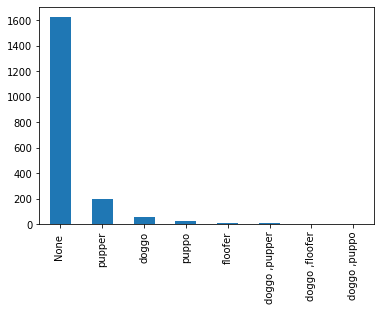

In [234]:
# bar chart distribution of dog stages
df['stage'].value_counts().plot(kind='bar')

In [233]:
df.stage.value_counts()

None              1625
pupper             199
doggo               59
puppo               21
floofer              7
doggo ,pupper        7
doggo ,floofer       1
doggo ,puppo         1
Name: stage, dtype: int64

Excluding the `None` dog stage for dogs without stages, `Pupper` is the most popular dog stage and `Floofer` is the least floofer dog stage. Dogs with multiple stages are not common as only 7 dogs were both `doggo and pupper`. The other 2 dogs belonged to both `doggo and floofer` stage, and `doggo and puppo` stage. 

#### WeRateDogs Tweet trend over time

In [212]:
data = df.tweet_id.groupby([df["timestamp"].dt.year, df["timestamp"].dt.month]).count()
data

timestamp  timestamp
2015       11           292
           12           358
2016       1            167
           2            109
           3            117
           4             53
           5             55
           6             78
           7             85
           8             55
           9             54
           10            55
           11            47
           12            52
2017       1             60
           2             61
           3             46
           4             41
           5             42
           6             43
           7             48
           8              2
Name: tweet_id, dtype: int64

/Users/bethel/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: `Series.plot()` should not be called with positional arguments, only keyword arguments. The order of positional arguments will change in the future. Use `Series.plot(kind='line')` instead of `Series.plot('line',)`.
  


Text(0, 0.5, 'Number of Tweets')

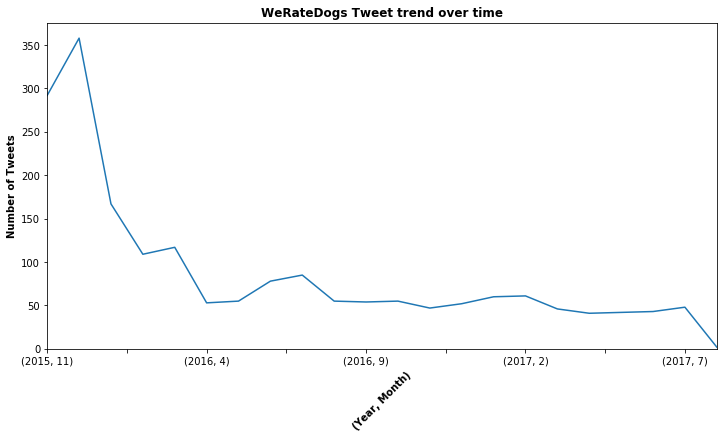

In [228]:
plt.subplots(figsize=(12, 6))
data.plot('line').set_ylim(0, )
plt.title('WeRateDogs Tweet trend over time', weight='bold')
plt.xlabel('(Year, Month)', weight='bold', rotation=45)
plt.ylabel('Number of Tweets', weight='bold')

The number of tweets sent out by WeRateDogs seem to have reduced over time

#### Rating dogs

In [214]:
df['rating_numerator'].value_counts().sort_index()

0         2
1         5
2         9
3        19
4        16
5        33
6        32
7        52
8        94
9       151
10      410
11      380
12      428
13      238
14       32
24        1
26        1
27        1
44        1
45        1
50        1
60        1
75        1
80        1
84        1
88        1
99        1
121       1
143       1
144       1
165       1
204       1
420       1
1776      1
Name: rating_numerator, dtype: int64

In [215]:
df['rating_numerator'][df['rating_numerator'] > 10].value_counts().sum()

1097

57% of the dogs were rated above 10. 